# Medición de diámetros a partir de una imagen patrón

In [ ]:
%pip install opencv-python
%pip install numba
%pip install tk

In [1]:
from functions import *     # Funciones definidas en functions.py (Para VS Code agregar dir. en carpeta AppData, settings.json)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from metas_unclib import *
use_linprop()
from tkinter import Tk  
from tkinter.filedialog import askopenfilename

In [2]:
DIR = "C:\\Users\\Admin\\Documents\\SEM Lineas de Aire\\Mediciones" # Directorio base para varias imágenes

ENDEREZAR = True   # True para enderezar las imágenes
CANNY = True    # Define el método utilizado para la detección de bordes. Canny_Edges si True, Thresholding si False.
# Para cada método conviene optimizar previamente los hiperparámetros (como el umbral) según la imagen.

In [4]:
# Ventana para selección de archivos
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

path_patron = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione Patrón', initialdir=DIR)
path_dut = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione DUT', initialdir=DIR)

## Procesamiento

Utiliza uno de los métodos de deteccion y optimiza el ángulo de rotación (si ENDEREZAR = True). Siempre verificar la imagen de salida!

Comprobar las imágenes de entrada

In [9]:
# Comprobar las imágenes
SCALE = 15  # Factor de escala para visualización

patron = cv2.imread(path_patron, cv2.IMREAD_UNCHANGED)
if patron.dtype == 'uint16':
    patron = (patron/256).astype('uint8')
patron = delete_bottom(patron, 320)
# patron = delete_left(patron, 10)
# patron = delete_right(patron, 10)
show_image(patron, SCALE)

dut = cv2.imread(path_dut, cv2.IMREAD_UNCHANGED)
if dut.dtype == 'uint16':
    dut = (dut/256).astype('uint8')
dut = delete_bottom(dut, 320)
dut = delete_left(dut, 200)
dut = delete_right(dut, 300)
show_image(dut, SCALE)

### Definir los valores de umbral

In [10]:
if CANNY:
    # Otros parámetros a definir (ver función Canny_Edges)
    bs = 3 # blur_size
    l2g = True #L2gradient
    # ----------------------------------------
    dt1 = DefineThreshold(patron, Canny_Edges, two_params=True, scale=SCALE)
    th1_pat, th2_pat = dt1.get_th(blur_size = bs, L2gradient = l2g)

    dt1 = DefineThreshold(dut, Canny_Edges, two_params=True, scale=SCALE)
    th1_dut, th2_dut = dt1.get_th(blur_size = bs, L2gradient = l2g)
else:
    dt1 = DefineThreshold(patron, Thresholding, two_params=False, scale=SCALE)
    th1_pat, th2_pat = dt1.get_th()

    dt1 = DefineThreshold(dut, Thresholding, two_params=False, scale=SCALE)
    th1_dut, th2_dut = dt1.get_th()

Guardar Imagenes

In [72]:
if CANNY:
    edges1 = Canny_Edges(dut, th1_dut, th2_dut, l2g, bs)    #Deteccion de bordes
    edges2 = Canny_Edges(patron, th1_pat, th2_pat, l2g, bs)    #Deteccion de bordes
else:
    edges1 = Thresholding(dut, th1_dut, th2_dut)
    edges2 = Thresholding(patron, th1_pat, th2_pat)


save_img(edges1, path_dut, "bordes")
save_img(edges2, path_patron, "bordes")

### PATRÓN

ENDEREZAMIENTO

Posibles parámetros para elegir el angulo de rotación: 
- Tomar las distancias globalmente, cuando su media o su desvío sean mínimos.
- Agrupar los primeros y últimos pixeles, cuando el desvío de cada grupo sea menor.

Se encontraron mejores resultados con el segundo método, que es el que se incluye.

Desvío primer pixel (px)
Mejor angulo medido: -0.7894736842105263°
Mejor angulo ajustado: 1.0°. Score=0.676357496638144

Desvío último pixel (px)
Mejor angulo medido: 0.5789473684210527°
Mejor angulo ajustado: 1.0°. Score=0.35380468525967246

Elegido: 1.0


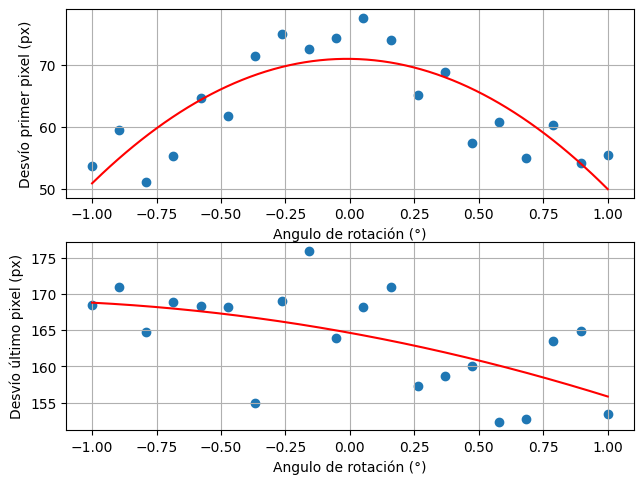

In [11]:
if ENDEREZAR:
    # Generar vector de grados, si el mínimo de la curva se encuentra
    # muy desplazado, volver a generarlo teniendo eso en cuenta.
    grados = np.linspace(-1, 1, 20) # Válido para ángulos pequeños (pueden perderse los bordes al cortar, verificar)
    results2 = []

    for i,g in enumerate(grados):   # Verifica uno a uno los ángulos
        img = rotate_and_cut(patron, g)  # Rota la imagen g grados
        if CANNY:
            edges = Canny_Edges(img, th1_pat, th2_pat, l2g, bs)    #Deteccion de bordes
        else:
            edges = Thresholding(img, th1_pat, th2_pat)
        
        # Mide todos los primeros y últimos pixeles
        firsts = []
        lasts = []
        for row in edges:
            f = first_pixel(row)
            l = last_pixel(row)
            if f:
                firsts.append(f)
            if l:
                lasts.append(l)
        results2.append( [np.std(firsts), np.std(lasts)])

    results2 = np.array(results2)

    # Ajuste y visualización
    fig, ax = plt.subplots(2)
    fig.tight_layout()
    angulo1 = ridge_grados(grados, results2[:,0], 2, ax[0], label="Desvío primer pixel (px)")
    angulo2 = ridge_grados(grados, results2[:,1], 2, ax[1], label="Desvío último pixel (px)")
    angulo_elegido = (angulo1 + angulo2)/2
    print("Elegido:", angulo_elegido)
else:
    angulo_elegido = 0

In [12]:
# Correccion a mano
angulo_elegido = -0.5

Medición final con ángulo elegido

Media inicial: 3797.0697501855057
Moda: 3744
Media final: 3749.3062345509475



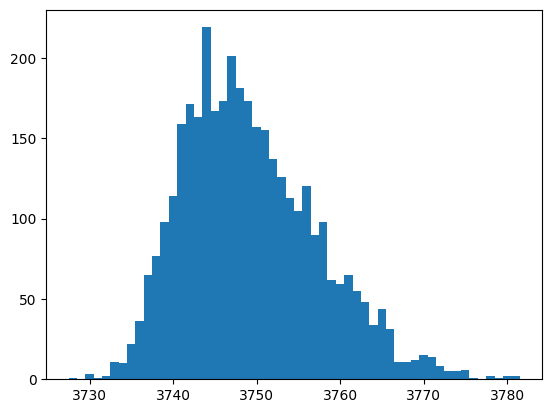

3641 filas con media 3749.3062345509475 (0.133750105947161) px



In [13]:
img = rotate_and_cut(patron, angulo_elegido)  # Rota la imagen g grados según lo ajustado
if CANNY:
    edges = Canny_Edges(img, th1_pat, th2_pat)    #Deteccion de bordes
else:
    edges = Thresholding(img, th1_pat, th2_pat)
show_image(edges, SCALE)
# cv2.imwrite(DIR + "Pat_Edges.bmp", edges)
diams1 = direct_distance(edges, outlier_percent=1, plot=True)   #Mide distancias entre bordes
mean_patron, u_patron = measure_distribution(diams1)   #Guarda las medias y desvios

### DUT

ENDEREZAMIENTO

Desvío primer pixel (px)
Mejor angulo medido: 0.10526315789473673°
Mejor angulo ajustado: 0.395256798058402°. Score=0.8966999942215977

Desvío último pixel (px)
Mejor angulo medido: 0.3157894736842106°
Mejor angulo ajustado: 0.1559053464919151°. Score=0.7897015965978462

Elegido: 0.27558107227515855


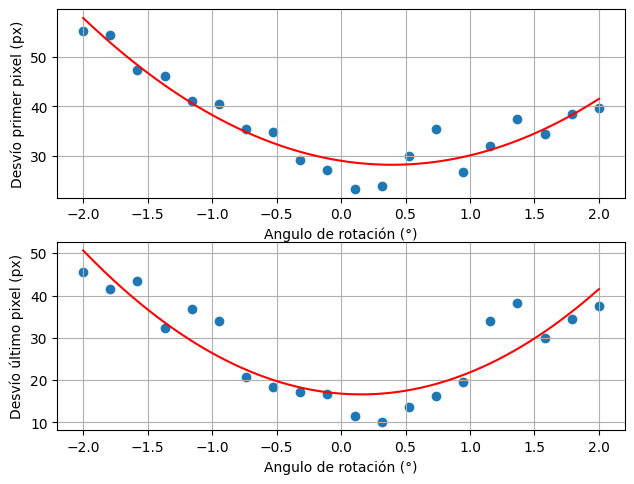

In [14]:
if ENDEREZAR:
    # Generar vector de grados, si el mínimo de la curva se encuentra
    # muy desplazado, volver a generarlo teniendo eso en cuenta
    grados = np.linspace(-2, 2, 20) # Válido para ángulos pequeños (pueden perderse los bordes al cortar, verificar)
    results = []

    for i,g in enumerate(grados):   # Verifica uno a uno los ángulos
        img = rotate_and_cut(dut, g)  # Rota la imagen g grados
        if CANNY:
            edges = Canny_Edges(img, th1_dut, th2_dut, l2g, bs)    #Deteccion de bordes
        else:
            edges = Thresholding(img, th1_dut, th2_dut)
        
        firsts = []
        lasts = []
        for row in edges:
            f = first_pixel(row)
            l = last_pixel(row)
            if f:
                firsts.append(f)
            if l:
                lasts.append(l)
        results.append( [np.std(firsts), np.std(lasts)])

    results = np.array(results)
    
    fig, ax = plt.subplots(2)
    fig.tight_layout()
    angulo1 = ridge_grados(grados, results[:,0], 2, ax[0], alpha=0, label="Desvío primer pixel (px)")
    angulo2 = ridge_grados(grados, results[:,1], 2, ax[1], alpha=0, label="Desvío último pixel (px)")
    angulo_elegido = (angulo1 + angulo2)/2
    print("Elegido:", angulo_elegido)
else:
    angulo_elegido = 0

In [95]:
#Ajuste a mano
angulo_elegido = 0.2

Medición final con ángulo elegido

Media inicial: 4416.974434611603
Moda: 4403
Media final: 4413.820865649237



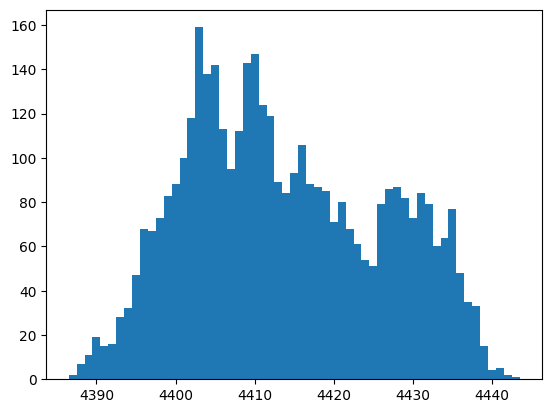

3997 filas con media 4413.820865649237 (0.19409849015866978) px



In [16]:
img = rotate_and_cut(dut, angulo_elegido)  # Rota la imagen g grados según lo ajustado
if CANNY:
    edges = Canny_Edges(img, th1_dut, th2_dut, l2g, bs)    #Deteccion de bordes
else:
    edges = Thresholding(img, th1_dut, th2_dut)
# cv2.imwrite(DIR + "DUT_Edges.bmp", edges)
show_image(edges, SCALE)
diams1 = direct_distance(edges, outlier_percent=1, plot=True)   #Mide distancias entre bordes
mean_dut, u_dut = measure_distribution(diams1)   #Guarda las medias y desvios

## Cálculo

In [17]:
# ---------------- Parámetros -----------------

DIAMETRO_PATRON = 1270 # diámetro medido del patrón (micrómetros)
INCERTIDUMBRE_PATRON = 0.023 # incert. patrón

diam_patron = ufloat(DIAMETRO_PATRON, INCERTIDUMBRE_PATRON, id='1', desc="Magnitud del Patrón")
media_patron = ufloat(mean_patron, u_patron, id='2', desc="Media de pixeles del patrón")

media_dut = ufloat(mean_dut, u_dut, id='3', desc="Media de pixeles del DUT")

In [18]:
peso_pixel = diam_patron/media_patron
result = peso_pixel * media_dut

print("Peso de 1 pixel:", peso_pixel, "um")
print(f"El diametro resultante es de {result} micrometros")

Peso de 1 pixel: 0.33872933298874885 ± 5.949123058849794e-06 um
El diametro resultante es de 1495.0905977531881 ± 0.03948848861610321 micrometros


## Guardado

In [ ]:
ustorage.save_binary_file(peso_pixel, "peso_pixel_1_27.ufloat")
ustorage.save_binary_file(result, "diametro_linea_1_52.ufloat")